In [1]:

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import shapely
import datetime
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os
import kaleido 
import contextily as cx
if not os.path.exists("/home/nen/Python/images"):
    os.mkdir("/home/nen/Python/images")
    


In [3]:
#set the world and the geometry 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Reproject to Mercator (after dropping Antartica)
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]
world = world.to_crs("EPSG:3857") # world.to_crs(epsg=3395) would also work
#check
#ax=world.plot(color='none', edgecolor='black',facecolor="none")
#ax.set_title("Mercator");
crs=world.crs

## Processing ignintion points 


In [4]:
ignition = pd.read_csv('/perm/nen/pil/2020_GWLC_ignition.cvs')


In [5]:
#time in the right format 
ignition['time']= pd.to_datetime(ignition['time'], format='%Y-%m-%d')
#add day of the year 
ignition['DOY'] = ignition['time'].dt.dayofyear


In [6]:
#add season 

spring = range(60, 149)
summer = range(150, 239)
fall = range(240, 329)
# winter = everything else
ignition['season']=ignition['DOY'].apply(lambda x: 'Spring' if x in range(60, 149)  else 
                                         'Summer' if x in range(150, 239) else 
                                         'Fall' if x in range(240, 329) else 'Winter')

#add lightning
ignition['lightning']=ignition['litota6'].apply(lambda x: True if x >0  else False)
ignition['lightning_obs']=ignition['density'].apply(lambda x: True if x >0  else False)

#Transform the points into a geopand array

In [7]:
ignition_gdf = gpd.GeoDataFrame(ignition,   geometry=gpd.points_from_xy(ignition.longitude, ignition.latitude),
                                crs=world.crs)
ignition_gdf = ignition_gdf.rename({'STRF': 'Biome'}, axis=1)  # new method


In [8]:

#biomes
ignition_gdf["Biome"].replace({1: "SA"}, inplace=True) 
ignition_gdf["Biome"].replace({2: "SA"}, inplace=True) 
ignition_gdf["Biome"].replace({5: "TF"}, inplace=True) 
ignition_gdf["Biome"].replace({6: "PEAT"},inplace=True) 
ignition_gdf["Biome"].replace({7: "EF"}, inplace=True)
ignition_gdf["Biome"].replace({8: "EF"}, inplace=True) 
ignition_gdf


latitude  longitude Biome   frpfire       time  ignition_no  ign_burn  \
0         56.35    -114.55    EF  0.934260 2020-01-01          1.0       6.0   
1         13.15     100.95    SA  0.551698 2020-01-01          1.0       6.0   
2         11.55      19.15    SA  0.538036 2020-01-01          1.0       6.0   
3         11.05      22.25    SA  0.535680 2020-01-01          1.0       6.0   
4         10.95      21.55    SA  1.858154 2020-01-01          1.0       6.0   
...         ...        ...   ...       ...        ...          ...       ...   
30074    -26.95      30.75    SA  0.954846 2020-12-30          1.0       6.0   
30075    -33.65      19.45    SA  0.751740 2020-12-30          1.0       6.0   
30076    -37.65     -65.75    SA  0.505859 2020-12-30          1.0       6.0   
30077    -37.75     -65.75    SA  4.463509 2020-12-30          1.0       6.0   
30078    -39.35     -64.15    SA  1.271357 2020-12-30          1.0       6.0   

       spread_zone  litota6  density  DOY  season  lightning  lightning_obs  \
0              0.0  0.00000      0.0    1  Winter      False          False   
1              0.0  0.00000      0.0    1  Winter      False          False   
2              0.0  0.00000      0.0    1  Winter      False          False   
3              0.0  0.00000      0.0    1  Winter      False          False   
4              0.0  0.00000      0.0    1  Winter      False          False   
...            ...      ...      ...  ...     ...        ...            ...   
30074          0.0  0.00246      0.0  365  Winter       True          False   
30075          0.0  0.00000      0.0  365  Winter      False          False   
30076          0.0  0.21059      0.0  365  Winter       True          False   
30077          0.0  0.00000      0.0  365  Winter      False          False   
30078          0.0  0.00000      0.0  365  Winter      False          False   

                      geometry  
0      POINT (-114.550 56.350)  
1       POINT (100.950 13.150)  
2        POINT (19.150 11.550)  
3        POINT (22.250 11.050)  
4        POINT (21.550 10.950)  
...                        ...  
30074   POINT (30.750 -26.950)  
30075   POINT (19.450 -33.650)  
30076  POINT (-65.750 -37.650)  
30077  POINT (-65.750 -37.750)  
30078  POINT (-64.150 -39.350)  

[30079 rows x 15 columns]

In [9]:
#drop columns not needed 
ignition_gdf.drop(columns=['latitude', 'longitude','litota6','density','ign_burn','ignition_no','spread_zone'])


Biome   frpfire       time  DOY  season  lightning  lightning_obs  \
0        EF  0.934260 2020-01-01    1  Winter      False          False   
1        SA  0.551698 2020-01-01    1  Winter      False          False   
2        SA  0.538036 2020-01-01    1  Winter      False          False   
3        SA  0.535680 2020-01-01    1  Winter      False          False   
4        SA  1.858154 2020-01-01    1  Winter      False          False   
...     ...       ...        ...  ...     ...        ...            ...   
30074    SA  0.954846 2020-12-30  365  Winter       True          False   
30075    SA  0.751740 2020-12-30  365  Winter      False          False   
30076    SA  0.505859 2020-12-30  365  Winter       True          False   
30077    SA  4.463509 2020-12-30  365  Winter      False          False   
30078    SA  1.271357 2020-12-30  365  Winter      False          False   

                      geometry  
0      POINT (-114.550 56.350)  
1       POINT (100.950 13.150)  
2        POINT (19.150 11.550)  
3        POINT (22.250 11.050)  
4        POINT (21.550 10.950)  
...                        ...  
30074   POINT (30.750 -26.950)  
30075   POINT (19.450 -33.650)  
30076  POINT (-65.750 -37.650)  
30077  POINT (-65.750 -37.750)  
30078  POINT (-64.150 -39.350)  

[30079 rows x 8 columns]

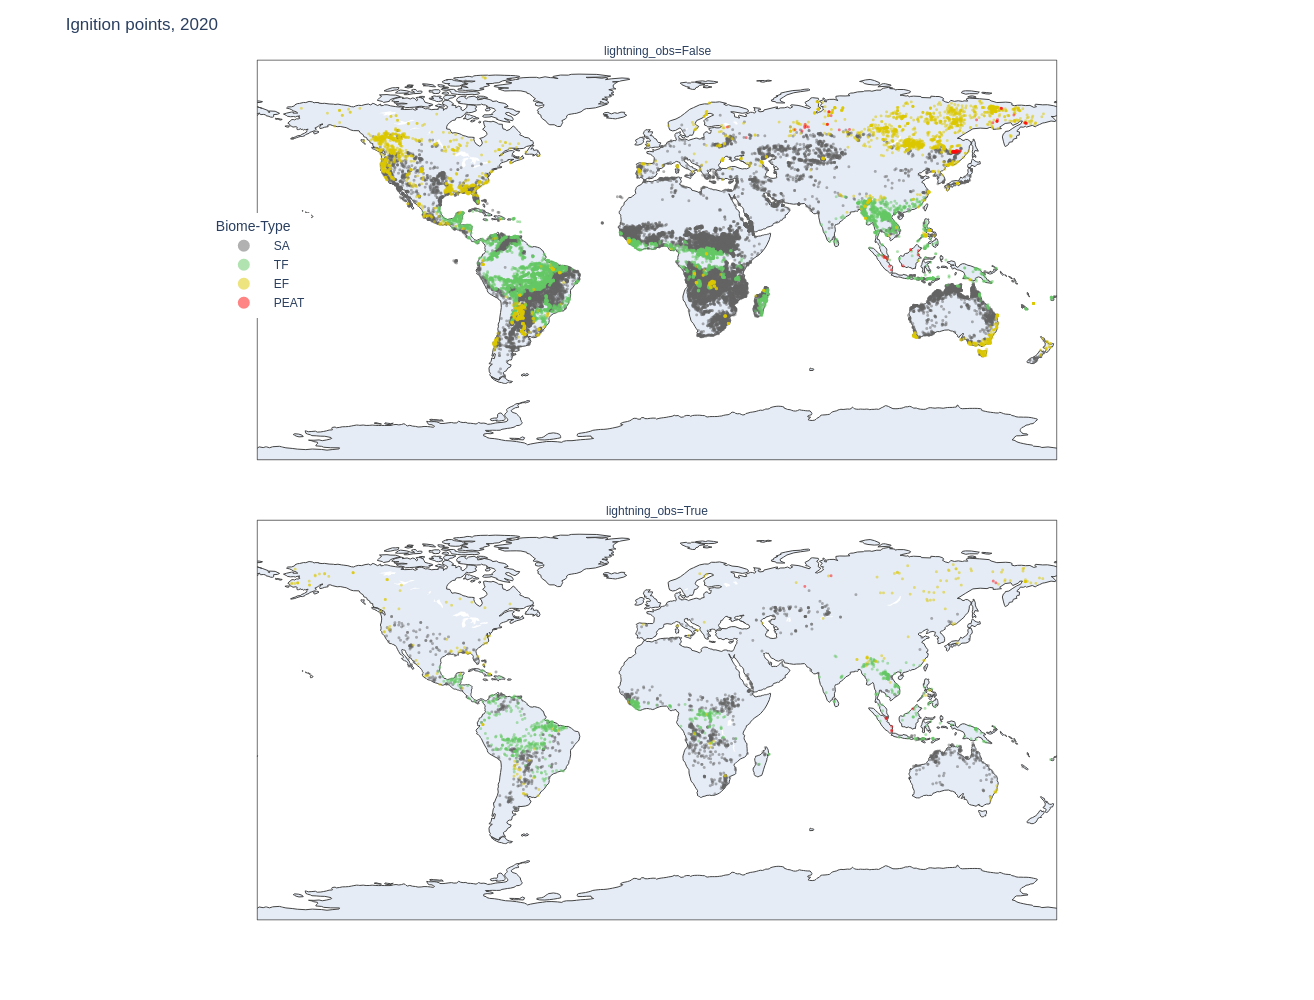

In [10]:
f1 = pd.DataFrame(ignition_gdf.drop(columns='geometry'))


fig = px.scatter_geo(f1,lat='latitude',lon='longitude', 
                     hover_name="frpfire", size_max=2, color="Biome",
                     color_discrete_sequence=["rgba(100,100,100,0.5)", "rgba(100,200,100,0.5)","rgba(220,200,0,0.5)","rgba(255,10,10,0.5)"],
                      category_orders={"Biome": ["SA", "TF","EF","PEAT"]}, facet_col='lightning_obs', facet_col_wrap=1)
fig.update_traces(marker={'size': 3})    
fig.update_layout(autosize=False,
    width=1000,
    height=1000, 
    title = 'Ignition points, 2020',legend_itemwidth=50,legend_itemsizing="constant")


fig.update_layout(legend=dict(yanchor="bottom", y=0.7, xanchor="right", x=0.2, title='Biome-Type'))
#im=fig.to_image(format="png", width=600, height=350, scale=2)
fig.write_image("/home/nen/Python/images/map_ignition.pdf", width=1000, height=1000, scale=1)
fig.show()
#f1.drop(['frpfire','ign_burn','spread_zone','ignition_no','time','longitude','litota6'],axis=1, inplace=True)


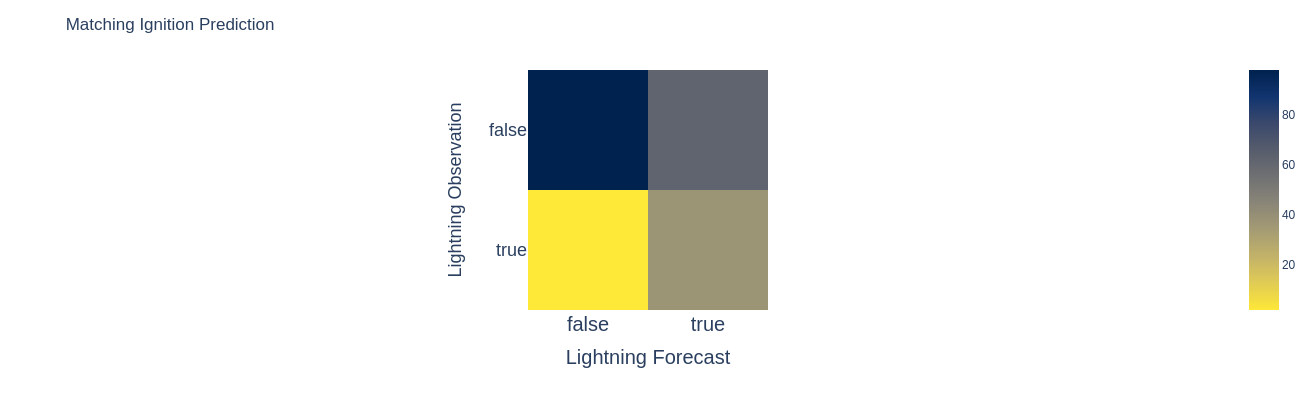

In [13]:
f2= f1[['lightning_obs','lightning']]
a=pd.crosstab(index=f2['lightning_obs'], columns=f2['lightning'])
tot=a.sum()
a=a/tot *100

fig = px.imshow(a,text_auto=True ,color_continuous_scale=px.colors.sequential.Cividis_r)
fig.update_layout(autosize=False,
    width=400,
    height=400,
    xaxis=dict(
        title_text="Lightning Forecast",
        tickfont=dict(size=20),
        titlefont=dict(size=20)
    ),
    yaxis=dict(
        title_text="Lightning Observation",
        tickfont=dict(size=18),
        titlefont=dict(size=18)
    ),
    title = 'Matching Ignition Prediction',legend_itemwidth=50,legend_itemsizing="constant")


fig.update_layout(legend=dict(yanchor="bottom", y=0.7, xanchor="right", x=0.2, title='Biome-Type'))
#im=fig.to_image(format="png", width=600, height=350, scale=2)
fig.write_image("/home/nen/Python/images/heatmap.pdf", width=600, height=350, scale=1)

fig.show()

In [14]:
# Numeber of ingnitions from lightning 

In [14]:
f2= f1.groupby(['lightning']).count()
tot=f2.ignition_no.sum()
f3=pd.DataFrame()
f3['fc']=f2['ignition_no']/tot*100
f2= f1.groupby(['lightning_obs']).count()
f3['obs']=f2['ignition_no']/tot*100
#f3=f3.melt(value_vars=['fc', 'obs'])
f3=f3.reset_index(level=0)
f3=f3.melt(id_vars='lightning',value_vars=['fc', 'obs'])




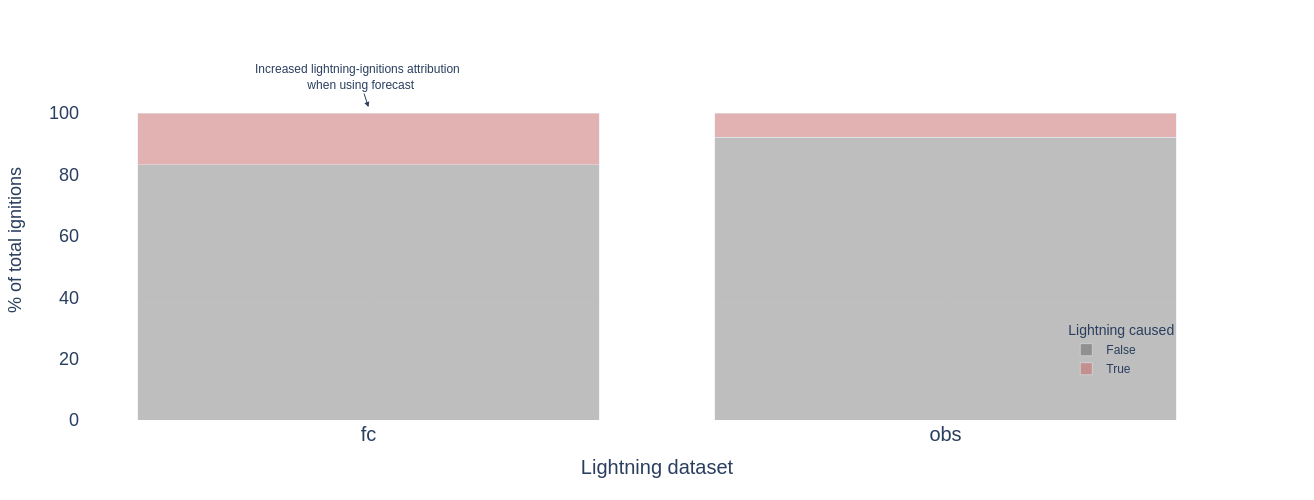

In [15]:
#Plotting 
fig = px.bar(f3,x='variable',y='value', color='lightning',
             color_discrete_sequence=["rgba(40,40,40,0.3)", "rgba(200,100,100,0.5)"])
fig.add_annotation(x=0, y=102,
            text=str("Increased lightning-ignitions attribution <br> when using forecast"),
            showarrow=True,
            arrowhead=2)

fig.update_layout(barmode='stack')
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(
        title_text="Lightning dataset",
        tickfont=dict(size=20),
        titlefont=dict(size=20)
    ),
    yaxis=dict(
        title_text="% of total ignitions",
        tickfont=dict(size=18),
        titlefont=dict(size=18)
    )

)
fig.update_layout({'plot_bgcolor' : 'rgba(0, 0, 0, 0.0)','paper_bgcolor' : 'rgba(0, 0, 0, 0.0)'})
fig.update_layout(legend=dict(yanchor="bottom", y=0.1, xanchor="right", x=0.95, title='Lightning caused'))
#im=fig.to_image(format="png", width=600, height=350, scale=2)
fig.write_image("/home/nen/Python/images/fig_bars_vertical.pdf", width=600, height=600, scale=1)
fig.show()

/etc/ecmwf/ssd/ssd1/tmpdirs/nen.18345763/ipykernel_659093/47049362.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/etc/ecmwf/ssd/ssd1/tmpdirs/nen.18345763/ipykernel_659093/47049362.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/etc/ecmwf/ssd/ssd1/tmpdirs/nen.18345763/ipykernel_659093/47049362.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/etc/ecmwf/ssd/ssd1/tmpdirs/nen.18345763/ipykernel_659093/47049362.py:9: SettingWi

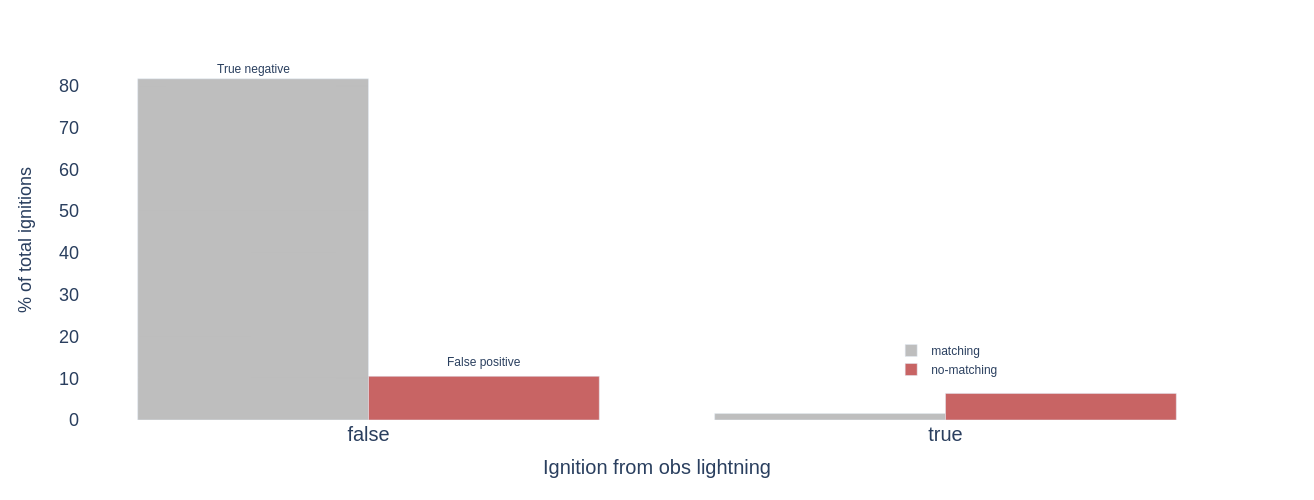

In [16]:

f2= f1.groupby(['lightning','lightning_obs']).count()
tot_ignition=f1['ignition_no'].sum()
f3=pd.DataFrame(f2.ignition_no).reset_index()
f3['matching']=f3['ignition_no']
f3['no-matching']=f3['ignition_no']
f3['matching'][0]=f3.loc[(f3['lightning_obs']==False) & (f3['lightning']==False),'ignition_no'].values
f3['no-matching'][0]=f3.loc[(f3['lightning_obs']==False) & (f3['lightning']==True),'ignition_no'].values
f3['matching'][1]=f3.loc[(f3['lightning_obs']==True) & (f3['lightning']==False),'ignition_no'].values
f3['no-matching'][1]=f3.loc[(f3['lightning_obs']==True) & (f3['lightning']==True),'ignition_no'].values

f3.drop([2,3],axis=0,inplace=True)
f3.drop(['ignition_no'],axis=1,inplace=True)

f3=f3.melt( id_vars=['lightning_obs','lightning'], value_vars=['matching', 'no-matching'])

f3['value']=f3['value']/tot*100

fig = px.bar(f3,x='lightning_obs',y='value', color='variable',
             color_discrete_sequence=["rgba(40,40,40,0.3)", "rgba(200,100,100,1)"])

fig.add_annotation(x=-0.2, y=84,
            text="True negative",
            showarrow=False,
            arrowhead=2)
fig.add_annotation(x=0.2, y=14,
            text="False positive",
            showarrow=False,
            arrowhead=2)

fig.update_layout(barmode='group')


fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(
        title_text="Ignition from obs lightning",
        tickfont=dict(size=20),
        titlefont=dict(size=20)
    ),
    yaxis=dict(
        title_text="% of total ignitions",
        tickfont=dict(size=18),
        titlefont=dict(size=18)
    )

)


fig.update_layout({'plot_bgcolor' : 'rgba(0, 0, 0, 0.0)','paper_bgcolor' : 'rgba(0, 0, 0, 0.0)'})
fig.update_layout(legend=dict(yanchor="bottom", y=0.1, xanchor="right", x=0.8, title=''))

#im=fig.to_image(format="png", width=600, height=350, scale=2)
fig.write_image("/home/nen/Python/images/fig_pies.pdf", width=600, height=600, scale=1)
fig.show()


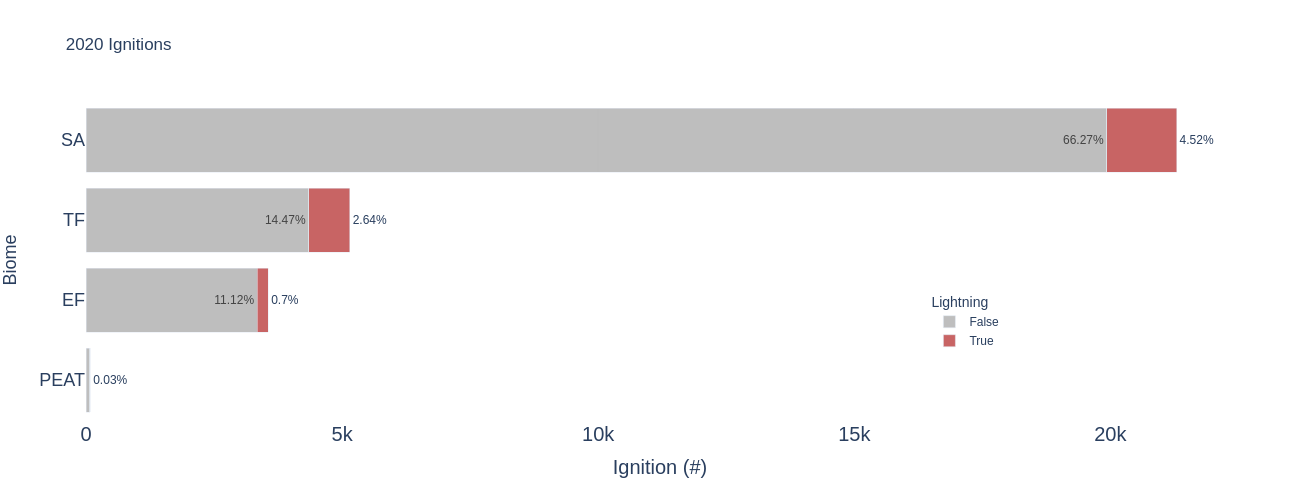

In [18]:
f2= f1.groupby(['Biome','lightning_obs']).count()
f3=pd.DataFrame(f2.ignition_no).reset_index()
tot=f3.ignition_no.sum()

f3['ignition_perc']=((f3['ignition_no']/tot)*100).round(2).astype(str)+'%'

fig = px.bar(f3, x="ignition_no", y="Biome", color='lightning_obs', text='ignition_perc',orientation='h',
              color_discrete_sequence=["rgba(40,40,40,0.3)", "rgba(200,100,100,1)","rgba(220,200,0,1)","rgba(255,10,10,1)"],
                 category_orders={"latitude": ['N-ExtraTropic', "Tropics", "S-ExtraTropic"],
                 #"season": ["Winter", "Spring", "Summer", "Fall"]
                              "Biome": ["SA", "TF","EF","PEAT"]},
             title='2020 Ignitions')
fig.update_layout(barmode='stack')
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    xaxis=dict(
        title_text="Ignition (#)",
        tickfont=dict(size=20),
        titlefont=dict(size=20)
    ),
    yaxis=dict(
        title_text="Biome",
        tickfont=dict(size=18),
        titlefont=dict(size=18)
    )

)

fig.update_layout(legend=dict(yanchor="bottom", y=0.2, xanchor="right", x=0.8, title='Lightning'))
fig.update_layout({'plot_bgcolor' : 'rgba(0, 0, 0, 0.0)','paper_bgcolor' : 'rgba(0, 0, 0, 0.0)'})
fig.write_image("/home/nen/Python/images/fig_bars_horizonatl.pdf", width=600, height=600, scale=1)
#fig.add_vrect(x0="Spring", x1="Summer", col=2,
#              annotation_text="Most of activity", annotation_position="top left",
#              fillcolor="green", opacity=0.25, line_width=0)
fig.show()


In [73]:
f2= f1.groupby(['Biome','lightning_obs']).count()
tot=f1.groupby(['Biome']).sum()
f3=pd.DataFrame(f2.ignition_no).reset_index()
tot=pd.DataFrame(tot.ignition_no).reset_index()

In [79]:
f3




Biome  lightning_obs  ignition_no
0    EF          False         3346
1    EF           True          210
2  PEAT          False           72
3  PEAT           True           10
4    SA          False        19934
5    SA           True         1359
6    TF          False         4353
7    TF           True          795

In [20]:
f2= f1.groupby(['lightning','lightning_obs']).count()

f3=pd.DataFrame(f2.ignition_no).reset_index()
tot=f3.ignition_no.sum()
f3['ignition_perc']=((f3['ignition_no']/tot)*100).round(2).astype(str)+'%'
f3

lightning  lightning_obs  ignition_no ignition_perc
0      False          False        24562        81.66%
1      False           True          459         1.53%
2       True          False         3143        10.45%
3       True           True         1915         6.37%

In [21]:
# different kind of plot 

In [19]:
#monthly means 
#bins = 30*np.arange(0,13,1)
#labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#lat_bins=[-75,-45,-30,30,45,75]
#lat_labels=['S-Polar','S-ExtraTropic','Tropics','N-ExtraTropic','N-Polar']
lat_bins=[-75,-30,30,75]
lat_labels=['S-ExtraTropic','Tropics','N-ExtraTropic']
#Cut by months 
#Cut by months 
#f2 = f1.groupby(['Biome',pd.cut(f1['latitude'],bins=lat_bins,labels=lat_labels),pd.cut(f1['DOY'],bins=bins,labels=labels)]).count()
#cut by seasons 
f2= f1.groupby(['Biome',pd.cut(f1['latitude'],bins=lat_bins,labels=lat_labels),'season','lightning']).count()
#no seasons
#f2= f1.groupby(['Biome',pd.cut(f1['latitude'],bins=lat_bins,labels=lat_labels),'lightning_obs'],group_keys=False).count()

In [20]:
f3=f2.stack(level=0).reset_index()
f3.rename(columns={0: 'count'}, inplace=True)
f3

Biome       latitude  season  lightning        level_4  count
0       EF  S-ExtraTropic    Fall      False       latitude     60
1       EF  S-ExtraTropic    Fall      False      longitude     60
2       EF  S-ExtraTropic    Fall      False        frpfire     60
3       EF  S-ExtraTropic    Fall      False           time     60
4       EF  S-ExtraTropic    Fall      False    ignition_no     60
...    ...            ...     ...        ...            ...    ...
1051    TF  N-ExtraTropic  Winter       True    spread_zone      0
1052    TF  N-ExtraTropic  Winter       True        litota6      0
1053    TF  N-ExtraTropic  Winter       True        density      0
1054    TF  N-ExtraTropic  Winter       True            DOY      0
1055    TF  N-ExtraTropic  Winter       True  lightning_obs      0

[1056 rows x 6 columns]

In [21]:
f3['count']=f3['count'].apply(lambda x: x if x >0  else np.nan)

def mask(lat,bio):
    flag=1
    if (lat=='Tropics' and bio=='EF'):
        flag=np.nan
    return flag
#print(mask('tropics','EF'))
#f3['mask']=f3.apply(lambda x: mask(x.latitude,x.Biome),axis=1)

f3=f3.dropna()
print(f3)

    Biome       latitude  season  lightning        level_4  count
0      EF  S-ExtraTropic    Fall      False       latitude   60.0
1      EF  S-ExtraTropic    Fall      False      longitude   60.0
2      EF  S-ExtraTropic    Fall      False        frpfire   60.0
3      EF  S-ExtraTropic    Fall      False           time   60.0
4      EF  S-ExtraTropic    Fall      False    ignition_no   60.0
..    ...            ...     ...        ...            ...    ...
963    TF        Tropics  Winter       True    spread_zone  247.0
964    TF        Tropics  Winter       True        litota6  247.0
965    TF        Tropics  Winter       True        density  247.0
966    TF        Tropics  Winter       True            DOY  247.0
967    TF        Tropics  Winter       True  lightning_obs  247.0

[748 rows x 6 columns]


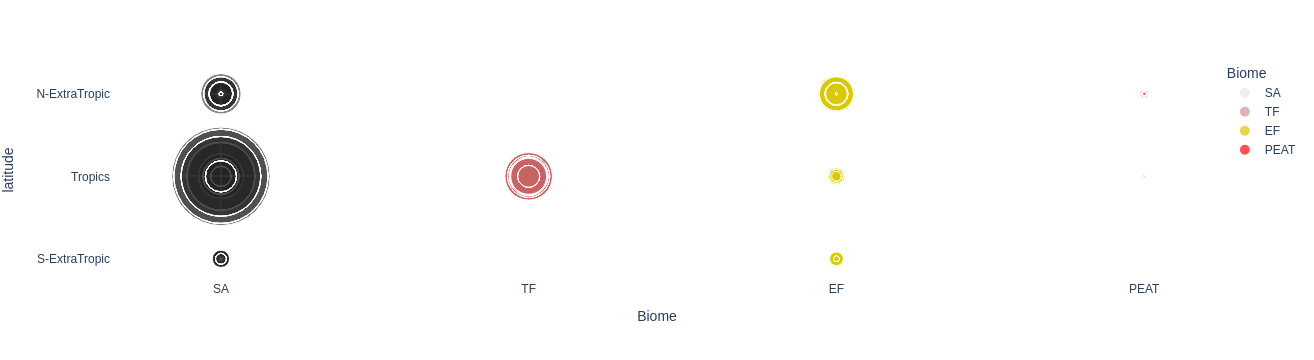

In [24]:

fig = px.scatter(f3, x="Biome", y="latitude",
                size="count", 
                color="Biome", 
                hover_name="Biome", log_x=False, 
               color_discrete_sequence=["rgba(40,40,40,0.1)", "rgba(200,100,100,0.7)","rgba(220,200,0,1)","rgba(255,10,10,1)"],
                category_orders={"latitude": ['N-ExtraTropic', "Tropics", "S-ExtraTropic"],
                 "season": ["Winter", "Spring", "Summer", "Fall"],
                            "Biome": ["SA", "TF","EF","PEAT"]},
              size_max=70)#facet_col='lightning', facet_col_wrap=0)
             
#fig.update_traces(
#       line=dict(color='gray', width=0)
#)

fig.update_layout({'plot_bgcolor' : 'rgba(0, 0, 0, 0.0)','paper_bgcolor' : 'rgba(0, 0, 0, 0.0)'})
#fig.add_vrect(x0="Spring", x1="Summer", col=2,
#              annotation_text="Most of activity", annotation_position="top left",
#              fillcolor="green", opacity=0.25, line_width=0)
fig.show()
fig.write_image("/home/nen/Python/images/fig2.png", width=800, height=400, scale=2)